In [4]:
!pip install torch torchvision scikit-learn


In [5]:
from google.colab import files
import zipfile

uploaded = files.upload()  # Upload train.zip and val.zip

for file_name in uploaded:
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall()


Saving train.zip to train.zip
Saving val.zip to val.zip


RESNET


In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train", transform=transform_train)
val_dataset = ImageFolder("val", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [7]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layer) for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.3MB/s]


In [8]:
from torch import optim
from sklearn.metrics import classification_report

criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train the final layer

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Save model
torch.save(model.state_dict(), "resnet18_gender.pth")


Epoch 1, Loss: 24.0546
Epoch 2, Loss: 16.3450
Epoch 3, Loss: 13.9045
Epoch 4, Loss: 12.5201
Epoch 5, Loss: 11.5388
Epoch 6, Loss: 10.9623
Epoch 7, Loss: 10.3372
Epoch 8, Loss: 10.7919
Epoch 9, Loss: 9.7361
Epoch 10, Loss: 9.9379


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print("== Evaluation on val/ set ==")
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:   ", recall_score(y_true, y_pred))
print("F1-score: ", f1_score(y_true, y_pred))


== Evaluation on val/ set ==
Accuracy:  0.9123222748815166
Precision: 0.9180327868852459
Recall:    0.9795918367346939
F1-score:  0.9478138222849083


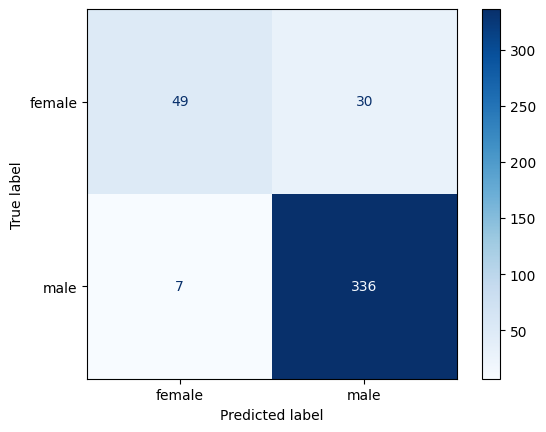

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [11]:
import json

# Step 1: Compute metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

# Step 2: Create dictionary
results = {
    "accuracy":  round(accuracy, 4),
    "precision": round(precision, 4),
    "recall":    round(recall, 4),
    "f1_score":  round(f1, 4)
}

# Step 3: Save as JSON
with open("results_task_a.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved evaluation metrics to results_task_a.json")


✅ Saved evaluation metrics to results_task_a.json


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_train_preds = []
all_train_labels = []

model.train()
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device).float().view(-1, 1)

    optimizer.zero_grad()
    outputs = model(images)  # Output: shape [batch_size, 1]
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    preds = (outputs > 0.5).float()  # Convert probabilities to binary (0/1)
    all_train_preds.extend(preds.cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())


In [13]:
# Compute metrics
train_accuracy  = accuracy_score(all_train_labels, all_train_preds)
train_precision = precision_score(all_train_labels, all_train_preds)
train_recall    = recall_score(all_train_labels, all_train_preds)
train_f1        = f1_score(all_train_labels, all_train_preds)

# Print results
print(f"Train Accuracy:  {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall:    {train_recall:.4f}")
print(f"Train F1-score:  {train_f1:.4f}")


Train Accuracy:  0.9283
Train Precision: 0.9476
Train Recall:    0.9686
Train F1-score:  0.9580


In [14]:
import json

train_results = {
    "train_accuracy": round(train_accuracy, 4),
    "train_precision": round(train_precision, 4),
    "train_recall": round(train_recall, 4),
    "train_f1_score": round(train_f1, 4)
}

with open("results_task_a_train.json", "w") as f:
    json.dump(train_results, f, indent=4)

print("✅ Training metrics saved to results_task_a_train.json")


✅ Training metrics saved to results_task_a_train.json
